In [17]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [18]:
#Lets find some entropy

In [19]:
rmax = 1000000000
num = 500

In [20]:
#lets do a 4d planar BH
d=4
k=0
#placeholders for other vars
l=1
q=0
mu=0

In [21]:
#lets define some functions?
def f(r,l=l,q=q,mu=mu,d=d,k=k):
    return k - mu*(r**(2-d)) + (q**2)*(r**(4-2*d)) + (r**2)/(l**2)

def fp(r,l=l,q=q,mu=mu,d=d):
    return (d-2)*mu*(r**(1-d)) + (4-2*d)*(q**2)*(r**(3-2*d))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R)

def gamma2(r0):
    return -1*f(r0)*(r0**(d-2))

In [22]:
#lets get a nice correlation between alpha and r0
def k1(r0,R):
    rbar = R / 2
    rgrid = np.linspace(rbar,r0,num)
    return (4 * np.pi / beta(R)) * np.trapz(1/f(rgrid),rgrid)

def k2(r0,R):
    rgrid = np.logspace(np.log10(R),np.log10(rmax),num)
    integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(r0)**2))))/f(rgrid)
    return (2*np.pi/beta(R)) * np.trapz(integ,rgrid)

def k3(r0,R):
    rgrid = np.linspace(r0,R,num)
    integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(r0)**2))))/f(rgrid)
    return (4*np.pi/beta(R)) * np.trapz(integ,rgrid)

In [23]:
def alpha(r0,R):
    return 2*np.exp(k1(r0,R)+k2(r0,R)+k3(r0,R))

In [30]:
alpha(10,40)

np.float64(0.3418876471035146)

In [31]:
#lets get an array relating r0 to alpha for fixed R=10
r0grid = np.linspace(1,100,num)
alphagrid = alpha(r0grid,10)

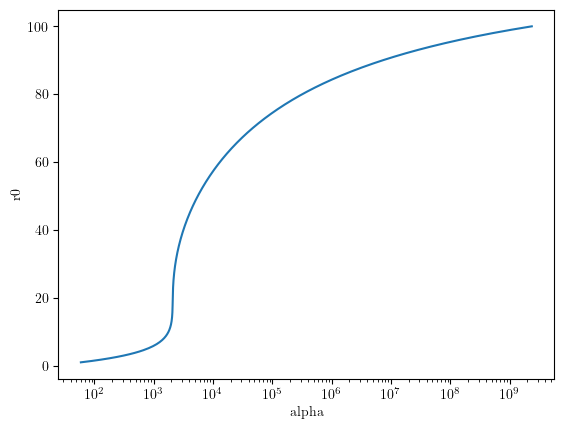

In [39]:
plt.plot(alphagrid,r0grid)
plt.xlabel('alpha')
plt.ylabel('r0')
plt.semilogx()
plt.show()